<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/5_updated_Ensembling_Momentum_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling Momentum Factors

We have seen a strong cross-sectional momentum effect.

In this notebook we're going to ensemble our momentum factors into a megafactor.

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "tibbletime","roll","RcppRoll","Hmisc","Rcpp"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




vctrs (0.6.4 -> 0.6.5) [CRAN]
bit   (4.0.4 -> 4.0.5) [CRAN]
cpp11 (0.4.6 -> 0.4.7) [CRAN]


Installing 3 packages: vctrs, bit, cpp11

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’



Hmisc installed



fansi    (1.0.5    -> 1.0.6   ) [CRAN]
processx (3.8.2    -> 3.8.3   ) [CRAN]
pkgbuild (1.4.2    -> 1.4.3   ) [CRAN]
desc     (1.4.2    -> 1.4.3   ) [CRAN]
progress (1.2.2    -> 1.2.3   ) [CRAN]
openssl  (2.0.6    -> 2.1.1   ) [CRAN]
jsonlite (1.8.7    -> 1.8.8   ) [CRAN]
curl     (5.0.2    -> 5.2.0   ) [CRAN]
gargle   (1.5.1    -> 1.5.2   ) [CRAN]
brio     (1.1.3    -> 1.1.4   ) [CRAN]
vroom    (1.6.4    -> 1.6.5   ) [CRAN]
testthat (3.2.0    -> 3.2.1   ) [CRAN]
arrow    (13.0.0.1 -> 14.0.0.2) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpA91Rhp/remotes2396fb0c484/RWLab-rwRtools-9f16cfc/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.66.tar.gz’

highr       (0.9   -> 0.10 ) [CRAN]
sass        (0

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex data

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

head(market_cap)

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,MarketCapUSD
<chr>,<date>,<dbl>
AGRS,2017-01-01,5.421921e+06
ATOM,2017-01-01,6.955437e+04
BTC,2017-01-01,1.568633e+10
DASH,2017-01-01,7.873666e+07
DCR,2017-01-01,1.702669e+06
DGB,2017-01-01,1.970633e+06


## Load Binance spot OHLCV

In [4]:
prices <- rwRtools::crypto_get_binance_spot_1h()
head(prices)

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 830.3 Mb )





File successfully transferred


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


# Creating research universe

In [5]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 22)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
min_constituents <- 10
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=min_constituents, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4336.80,72153449099,1,FALSE
2017-08-17,ETH,306.74,28752742413,2,FALSE
2017-08-18,BTC,4113.75,70206129858,1,FALSE
2017-08-18,ETH,293.74,28406320026,2,FALSE
2017-08-19,BTC,4139.98,67500579074,1,FALSE
2017-08-19,ETH,290.91,27839631816,2,FALSE


# Calculate Features

In [6]:
# Rolling days since high
rolling_days_since_high_15 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 15, na_value = NA),
  otherwise = NA
)
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 20, na_value = NA),
  otherwise = NA
)

rolling_days_since_high_25 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 25, na_value = NA),
  otherwise = NA
)
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 30, na_value = NA),
  otherwise = NA
)


features_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    mom_10 = log(Close / lag(Close, n = 10)),
    mom_15 = log(Close / lag(Close, n = 15)),
    mom_20 = log(Close / lag(Close, n = 20)),
    mom_25 = log(Close / lag(Close, n = 25))
  ) %>%
  # Close to SMA factor
  mutate(
    psma_15 = Close / roll_meanr(Close, 15) - 1,
    psma_20 = Close / roll_meanr(Close, 20) - 1,
    psma_25 = Close / roll_meanr(Close, 25) - 1,
    psma_30 = Close / roll_meanr(Close, 30) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    smaf_2_20 = roll_meanr(Close, 2) / roll_meanr(Close, 20) - 1,
    smaf_3_20 = roll_meanr(Close, 3) / roll_meanr(Close, 20) - 1,
    smaf_3_25 = roll_meanr(Close, 3) / roll_meanr(Close, 25) - 1,
    smaf_5_30 = roll_meanr(Close, 5) / roll_meanr(Close, 30) - 1.
  ) %>%
  # Rolling Close zscore over recent history
  mutate(
    rrp_15 = (Close - roll_meanr(Close, n = 15)) / roll_sdr(Close, n = 15),
    rrp_20 = (Close - roll_meanr(Close, n = 20)) / roll_sdr(Close, n = 20),
    rrp_25 = (Close - roll_meanr(Close, n = 25)) / roll_sdr(Close, n = 25),
    rrp_30 = (Close - roll_meanr(Close, n = 30)) / roll_sdr(Close, n = 20)
  ) %>%
  # Rolling days since recent high
  mutate(
    dsh_15 = -rolling_days_since_high_15(Close),
    dsh_20 = -rolling_days_since_high_20(Close),
    dsh_25 = -rolling_days_since_high_25(Close),
    dsh_30 = -rolling_days_since_high_30(Close),
  ) %>%
  # Calculate returns
  mutate(fwd_log_return_1 = log(lead(Close) / Close),
         fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
         fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2)),
         fwd_log_return_4 = log(lead(Close,4) / lead(Close, 3)),
         fwd_log_return_5 = log(lead(Close,5) / lead(Close, 4)),
         fwd_log_return_6 = log(lead(Close,6) / lead(Close, 5)),
         fwd_log_return_7 = log(lead(Close,7) / lead(Close, 6)),
         fwd_return_1 = lead(Close,1) / Close - 1,
         fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
         fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
         fwd_return_4 = lead(Close,4) / lead(Close, 3) - 1,
         fwd_return_5 = lead(Close,5) / lead(Close, 4) - 1,
         fwd_return_6 = lead(Close,6) / lead(Close, 5) - 1,
         fwd_return_7 = lead(Close,7) / lead(Close, 6) - 1
  ) %>%
  na.omit() %>%
  ungroup()

In [7]:
head(features_wide)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index,mom_10,mom_15,mom_20,mom_25,⋯,fwd_log_return_5,fwd_log_return_6,fwd_log_return_7,fwd_return_1,fwd_return_2,fwd_return_3,fwd_return_4,fwd_return_5,fwd_return_6,fwd_return_7
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-09-16,BTC,3710.00,60495396813,1,FALSE,-0.17589032,-0.23589213,-0.14758315,-0.08548506,⋯,-0.089969403,-0.008283180,0.03667597,0.002695418,0.08336022,-0.03657229,0.022115996,-0.086040851,-0.008248969,0.03735683
2017-09-16,ETH,254.00,23679488724,2,FALSE,-0.21691950,-0.41484356,-0.26357492,-0.22613121,⋯,-0.101240926,-0.002962851,0.07863665,0.012795276,0.13966958,-0.04505764,0.028681644,-0.096284722,-0.002958466,0.08181118
2017-09-17,BTC,3720.00,58836899904,1,FALSE,-0.22753176,-0.26384580,-0.14841074,-0.07307057,⋯,-0.008283180,0.036675971,-0.01663735,0.083360215,-0.03657229,0.02211600,-0.086040851,-0.008248969,0.037356833,-0.01649971
2017-09-17,ETH,257.25,23250092978,2,FALSE,-0.27003456,-0.41827548,-0.27539110,-0.18848973,⋯,-0.002962851,0.078636651,0.02010082,0.139669582,-0.04505764,0.02868164,-0.096284722,-0.002958466,0.081811175,0.02030421
2017-09-18,BTC,4030.10,64291653754,1,FALSE,-0.06156037,-0.08894907,-0.07714758,-0.02065321,⋯,0.036675971,-0.016637350,0.06595339,-0.036572293,0.02211600,-0.08604085,-0.008248969,0.037356833,-0.016499713,0.06817693
2017-09-18,ETH,293.18,26700964260,2,FALSE,-0.03000443,-0.11745705,-0.17282278,-0.07729449,⋯,0.078636651,0.020100825,0.02785273,-0.045057644,0.02868164,-0.09628472,-0.002958466,0.081811175,0.020304207,0.02824425


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum
 - Group by rank
 - Plot the mean log return n days after for each rank.

`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.


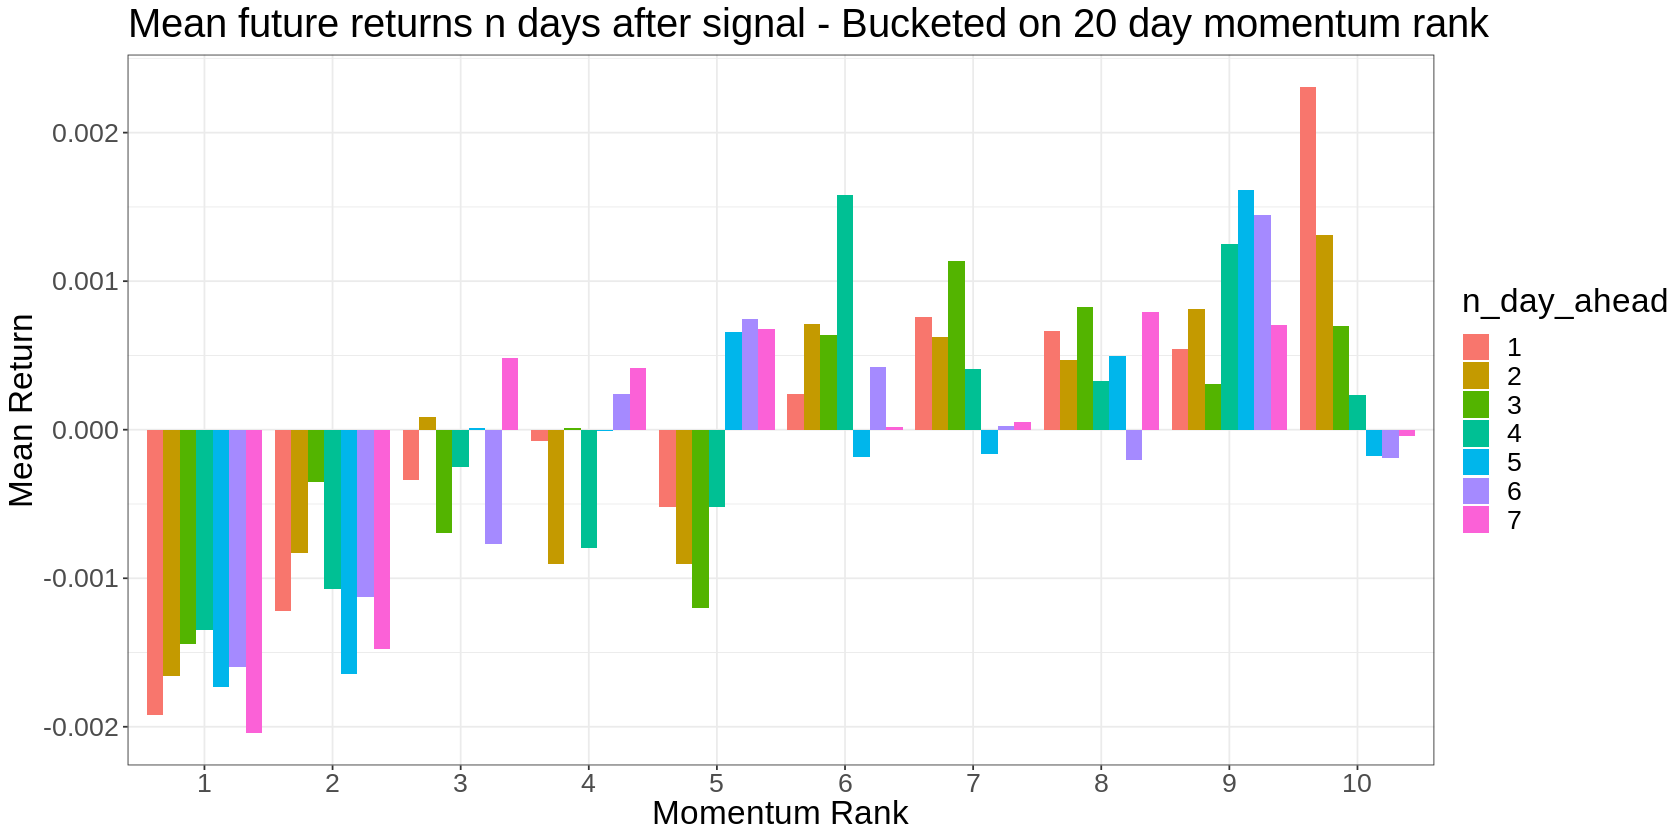

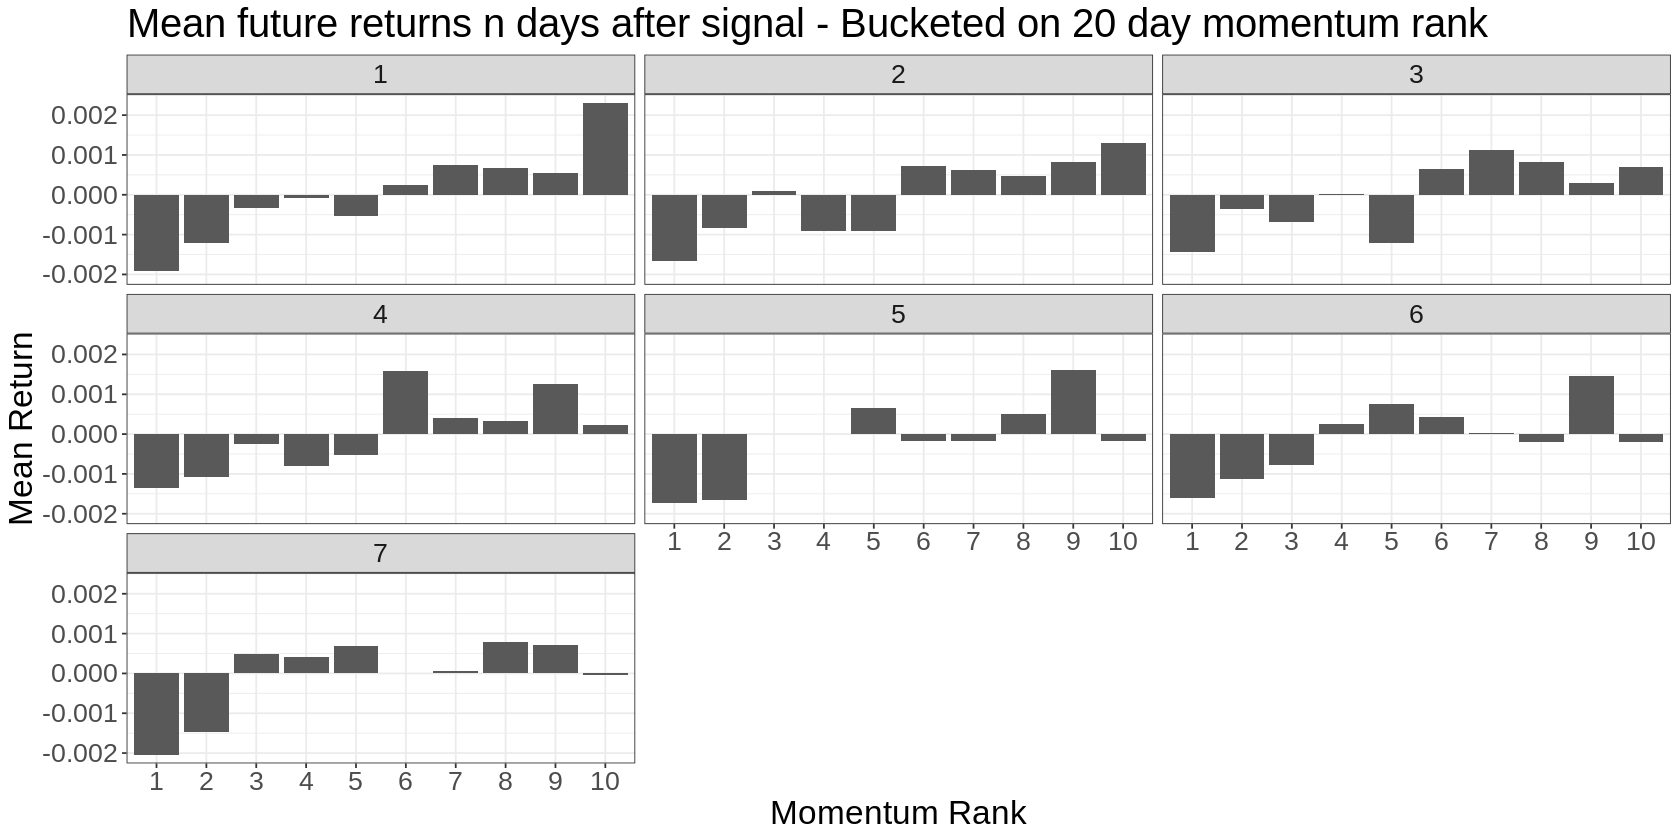

In [8]:
features_wide %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret, fill=n_day_ahead)) + geom_bar(stat='identity', position = 'dodge') +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

features_wide %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) + geom_bar(stat='identity', position = 'dodge') + facet_wrap(~n_day_ahead) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

It's a persistent effect, even if we take ages to act!!

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year', 'rank'. You can override using the
`.groups` argument.


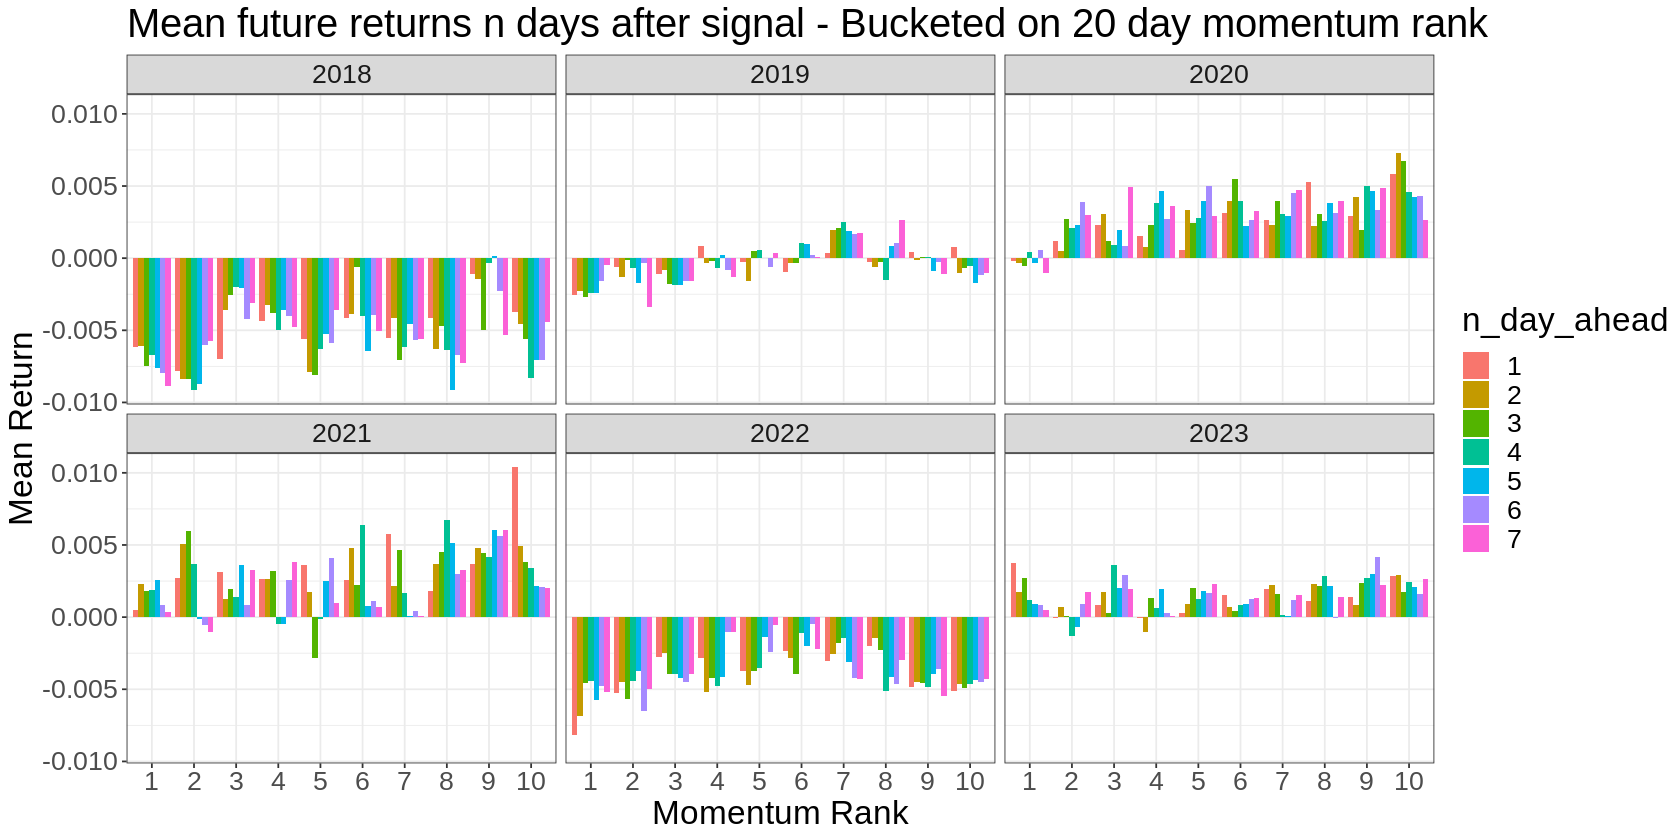

In [9]:
features_wide %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(year, rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret, fill=n_day_ahead)) +
    geom_bar(stat='identity', position = 'dodge') +
    facet_wrap(~year) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )



# Creating a factor time series

Now, we're going to construct a number of factor time series.

Weight all assets in proportion to their rank.


`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


n_day_ahead,meanreturn,vol,ir
<chr>,<dbl>,<dbl>,<dbl>
1,0.3894729,0.3010761,1.2936030
2,0.2961365,0.2865849,1.0333291
4,0.2222829,0.2735811,0.8124936
5,0.2189387,0.2767462,0.7911172
3,0.2120798,0.2810496,0.7545991
6,0.1905049,0.2660889,0.7159446
7,0.1888578,0.2658520,0.7103870


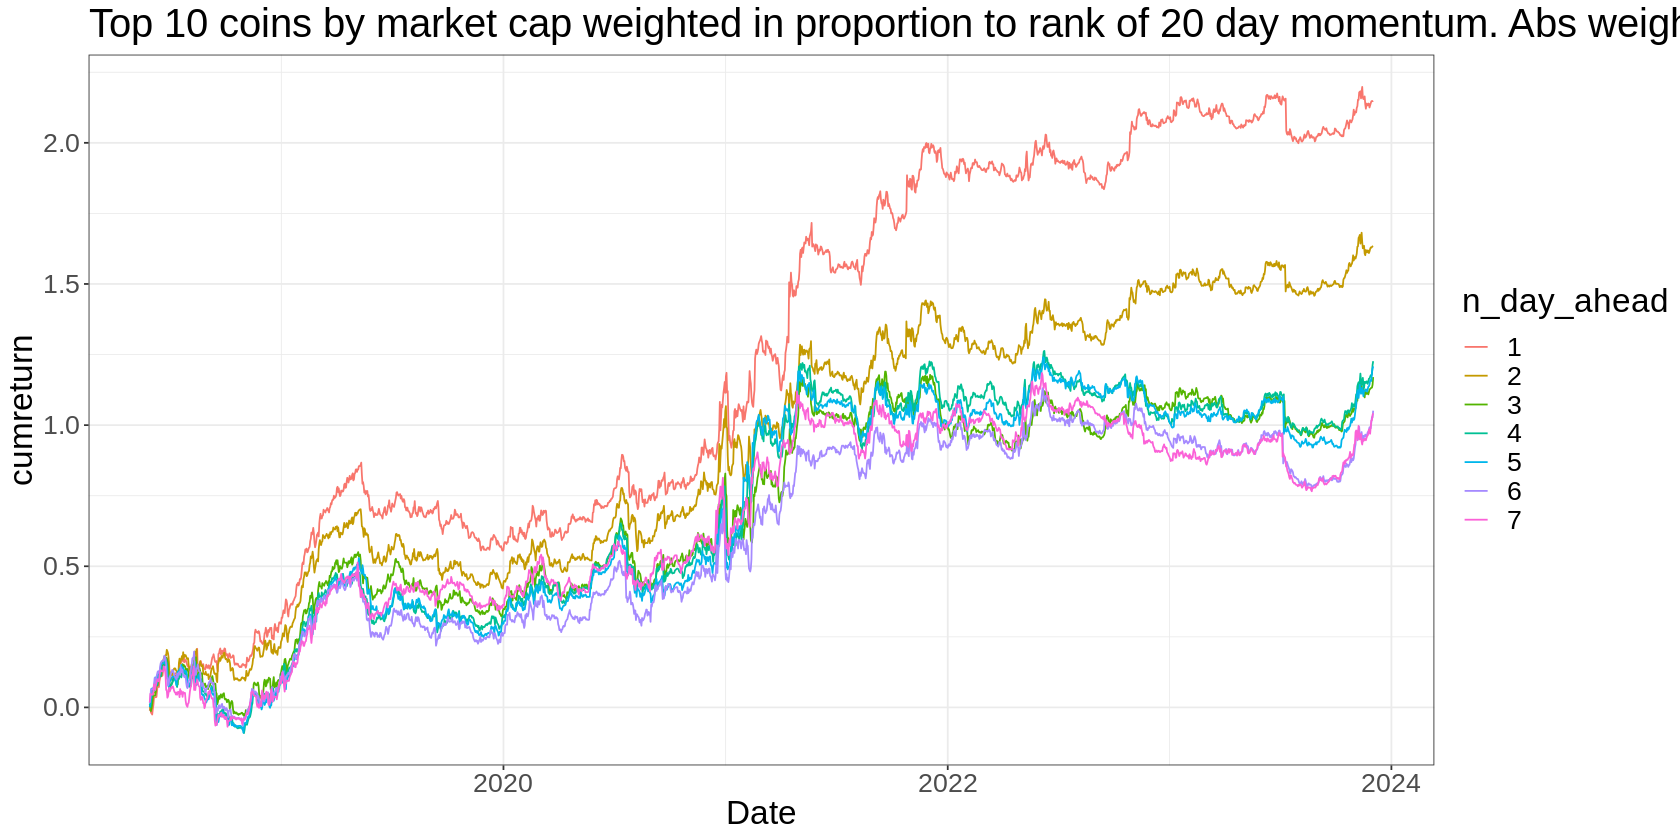

In [10]:
factor_returns <- features_wide %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, n_day_ahead) %>%
  mutate(
    rank = row_number(mom_20),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_returns %>%
  group_by(n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mom_20,1,0.38947287,0.3010761,1.2936030
mom_15,1,0.38380819,0.2985902,1.2854014
mom_25,1,0.36655248,0.2954976,1.2404583
mom_10,1,0.32155796,0.2959476,1.0865368
mom_15,2,0.30404256,0.2841410,1.0700413
mom_20,2,0.29613648,0.2865849,1.0333291
mom_25,2,0.27749762,0.2831552,0.9800194
mom_25,3,0.27163972,0.2761587,0.9836363
mom_20,3,0.21207977,0.2810496,0.7545991


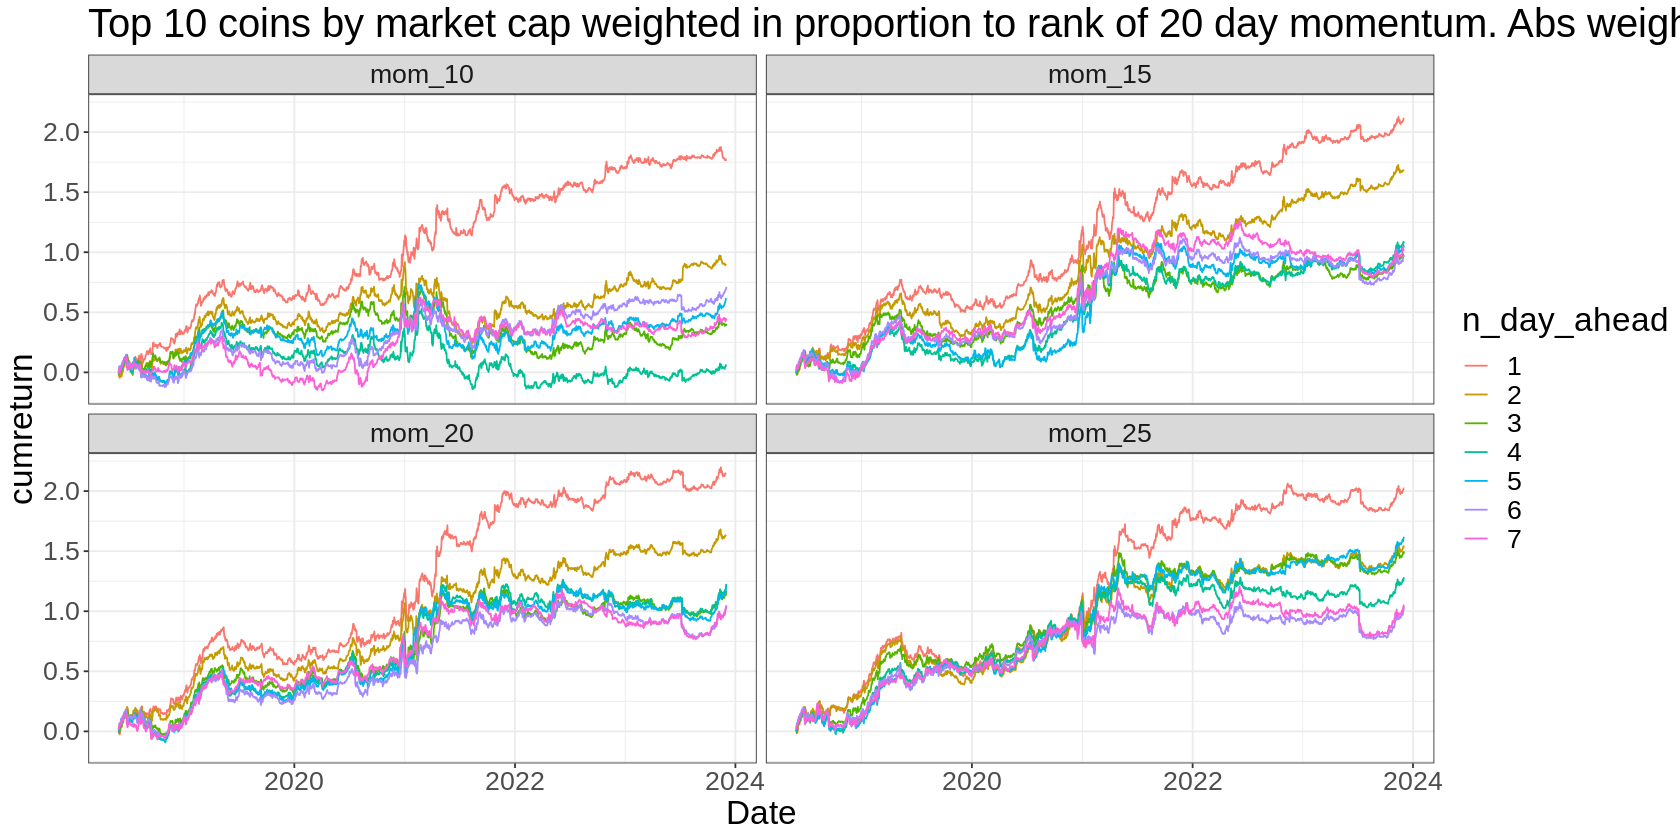

In [11]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('mom_'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Price to SMA Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
psma_20,1,0.4479862,0.3008150,1.4892414
psma_15,1,0.4426628,0.3027916,1.4619389
psma_25,1,0.4390431,0.3011652,1.4578149
psma_30,1,0.4340768,0.3010072,1.4420807
psma_30,2,0.2917108,0.2888398,1.0099397
psma_25,2,0.2852743,0.2907070,0.9813121
psma_20,2,0.2773822,0.2874630,0.9649317
psma_15,2,0.2290227,0.2851251,0.8032358
psma_30,3,0.2255209,0.2823993,0.7985888


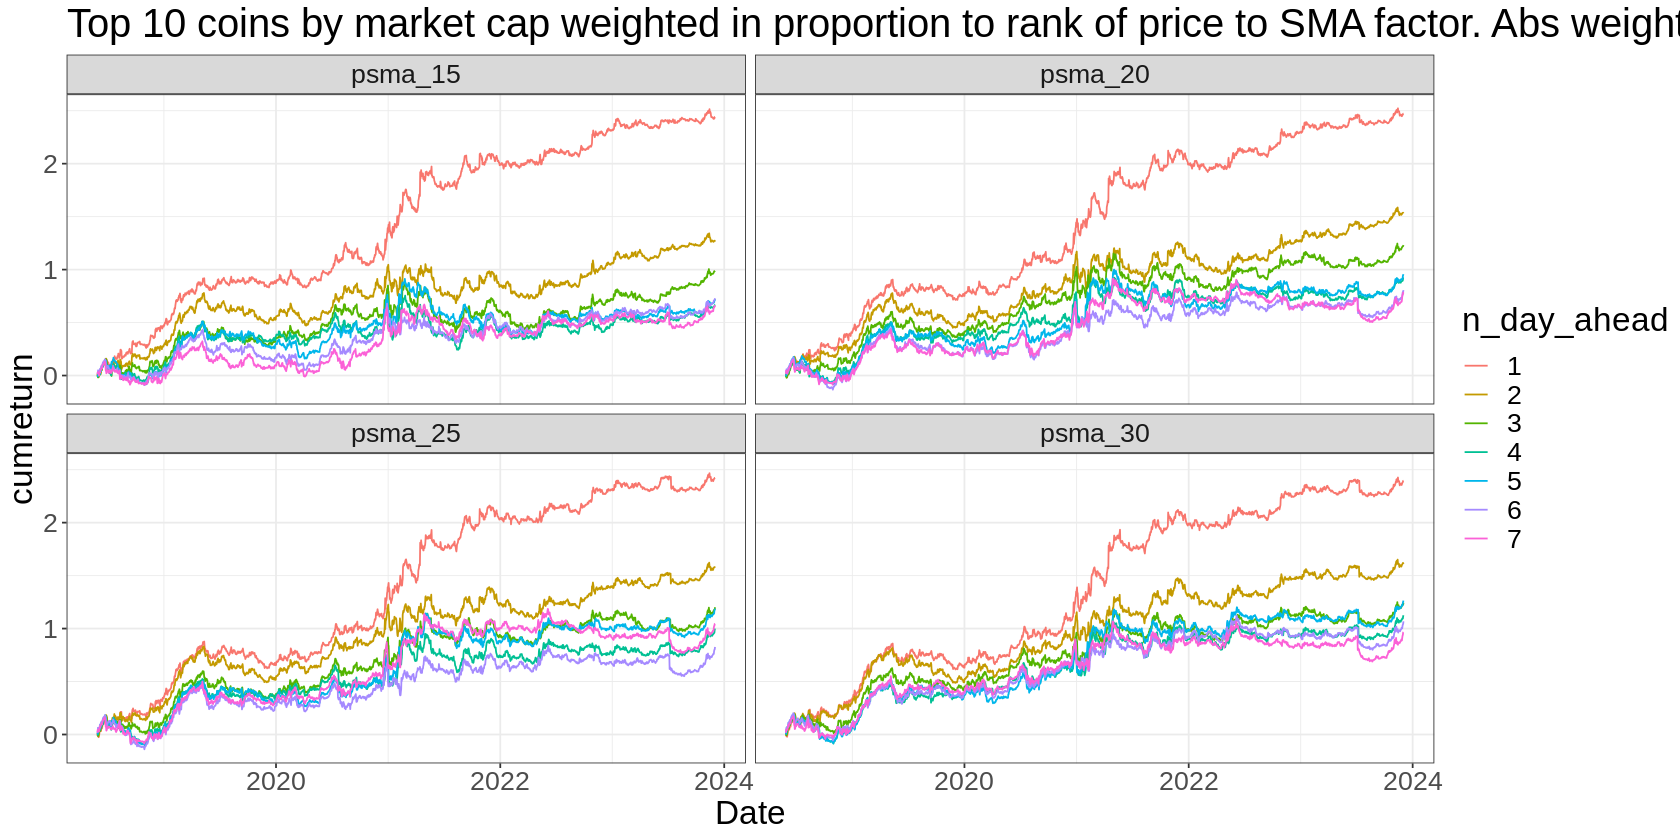

In [12]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('psma'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price to SMA factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# SMA Ratio Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
smaf_2_20,1,0.3899087,0.3009596,1.2955517
smaf_3_25,1,0.3779391,0.2985407,1.2659548
smaf_3_20,1,0.3746911,0.3012730,1.2436928
smaf_5_30,1,0.3089769,0.2943555,1.0496729
smaf_2_20,2,0.2677481,0.2861870,0.9355704
smaf_3_25,2,0.2599046,0.2867665,0.9063283
smaf_3_20,2,0.2436814,0.2850069,0.8550020
smaf_5_30,2,0.2380818,0.2831626,0.8407952
smaf_5_30,3,0.1927522,0.2788202,0.6913135


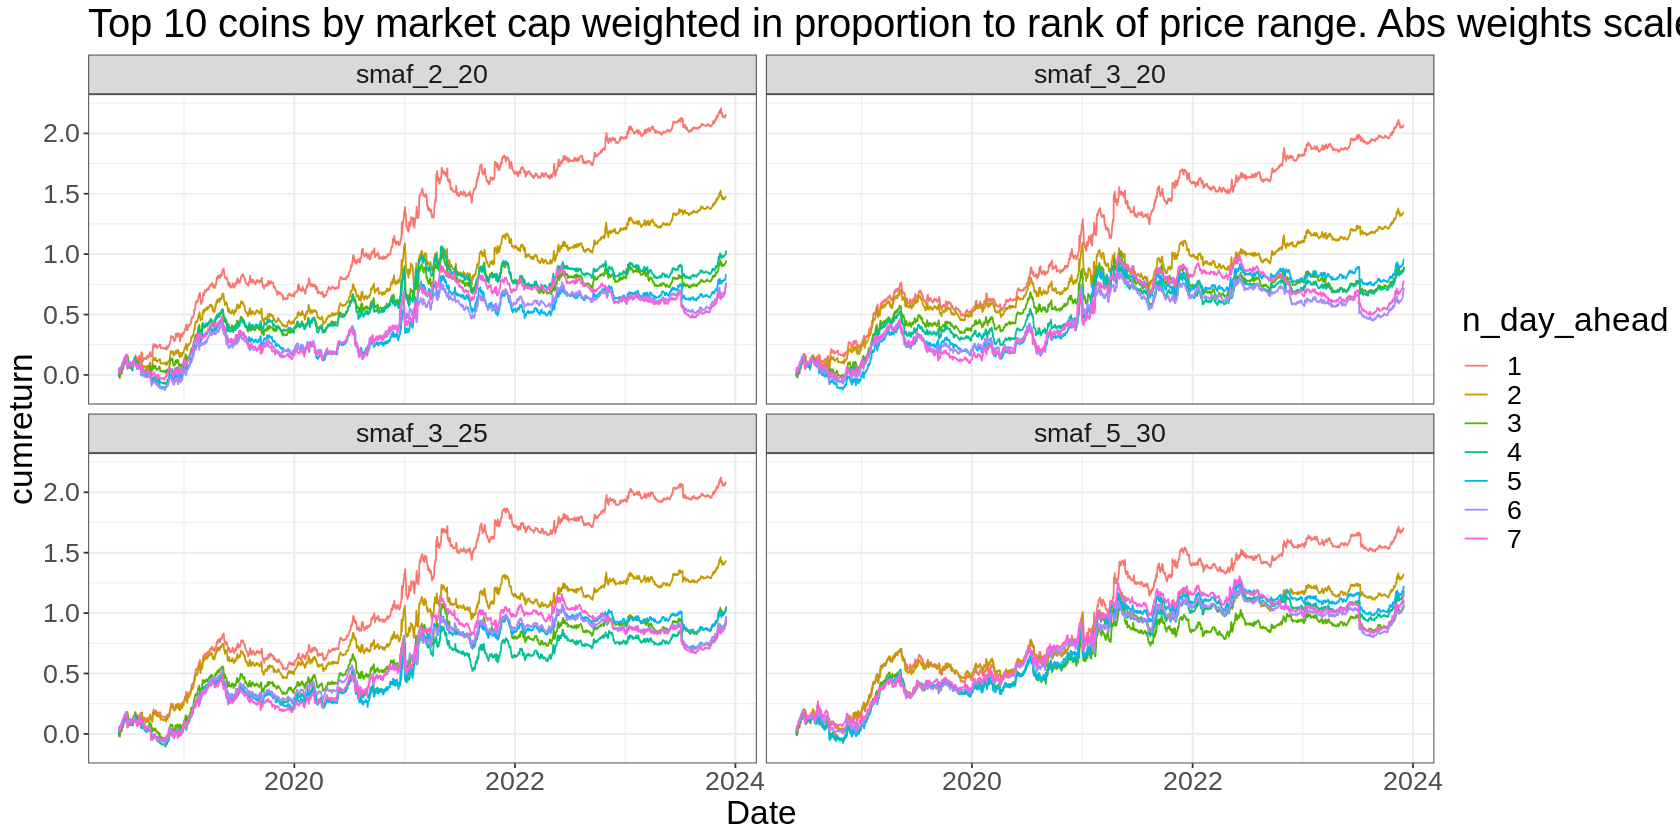

In [13]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('smaf'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Price Range Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
rrp_15,1,0.7665404,0.2893390,2.6492812
rrp_20,1,0.7200524,0.2871684,2.5074220
rrp_30,1,0.6351880,0.2835343,2.2402509
rrp_25,1,0.5985035,0.2849173,2.1006223
rrp_20,2,0.3060597,0.2669475,1.1465167
rrp_15,2,0.2956797,0.2616337,1.1301287
rrp_25,2,0.2921069,0.2687850,1.0867679
rrp_30,2,0.2802276,0.2695681,1.0395427
rrp_30,3,0.2789567,0.2575575,1.0830852


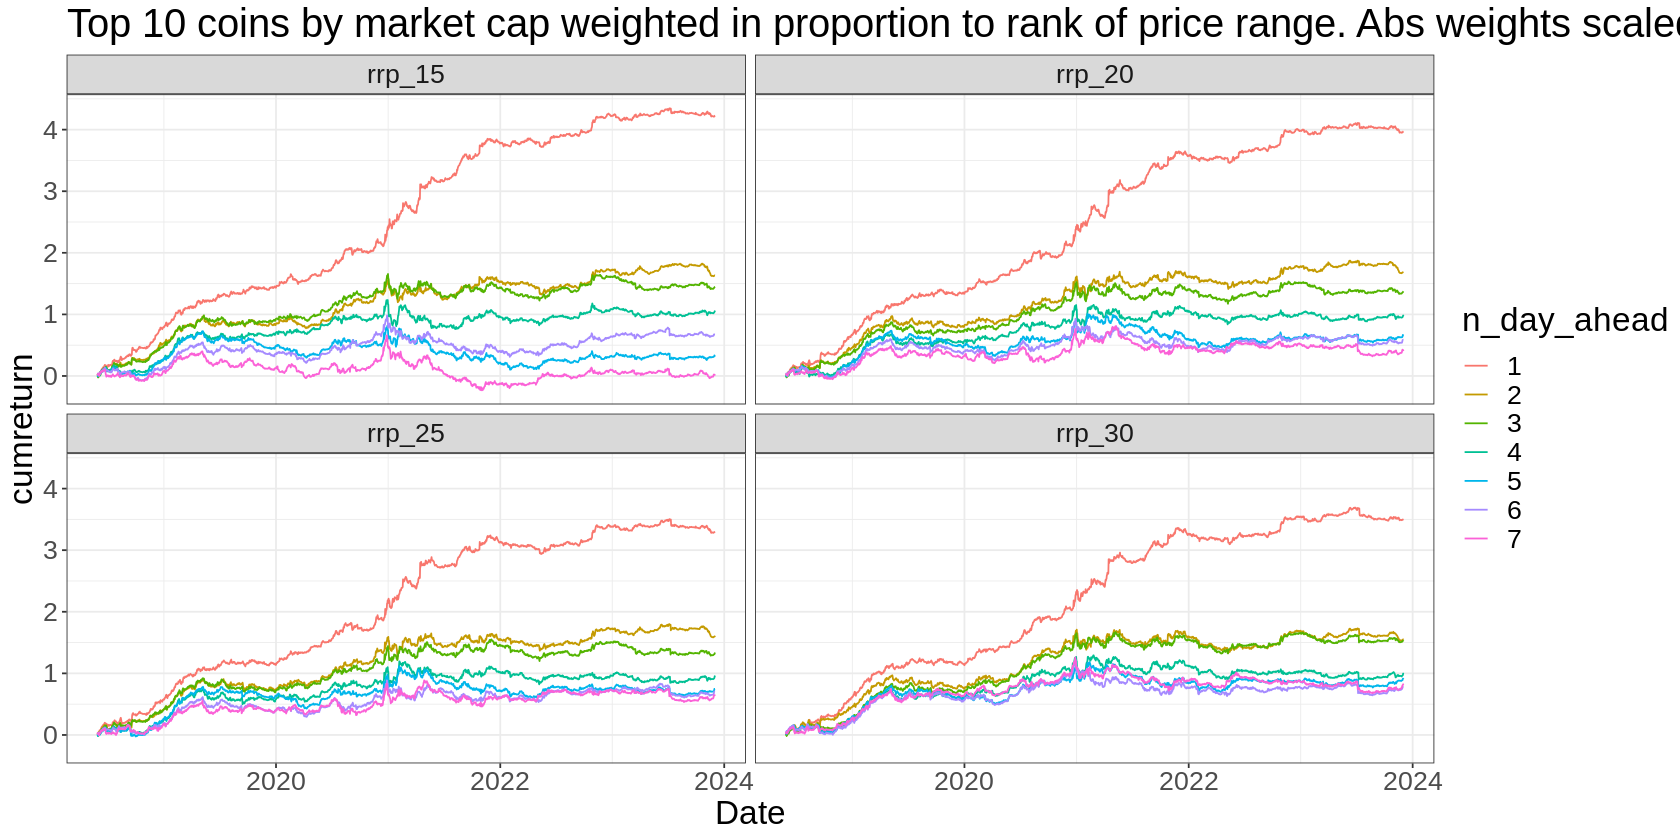

In [14]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('rrp'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Rolling Days Since High Factor

`summarise()` has grouped output by 'Date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
dsh_30,1,0.319688353,0.2543330,1.25696750
dsh_15,1,0.292843403,0.2527716,1.15852978
dsh_25,1,0.254265569,0.2547969,0.99791466
dsh_20,1,0.178590459,0.2568541,0.69529914
dsh_30,2,0.164984866,0.2408613,0.68497882
dsh_30,3,0.133449117,0.2389829,0.55840454
dsh_15,2,0.114319520,0.2405297,0.47528238
dsh_25,3,0.111927699,0.2449199,0.45699708
dsh_25,2,0.093944225,0.2453388,0.38291629


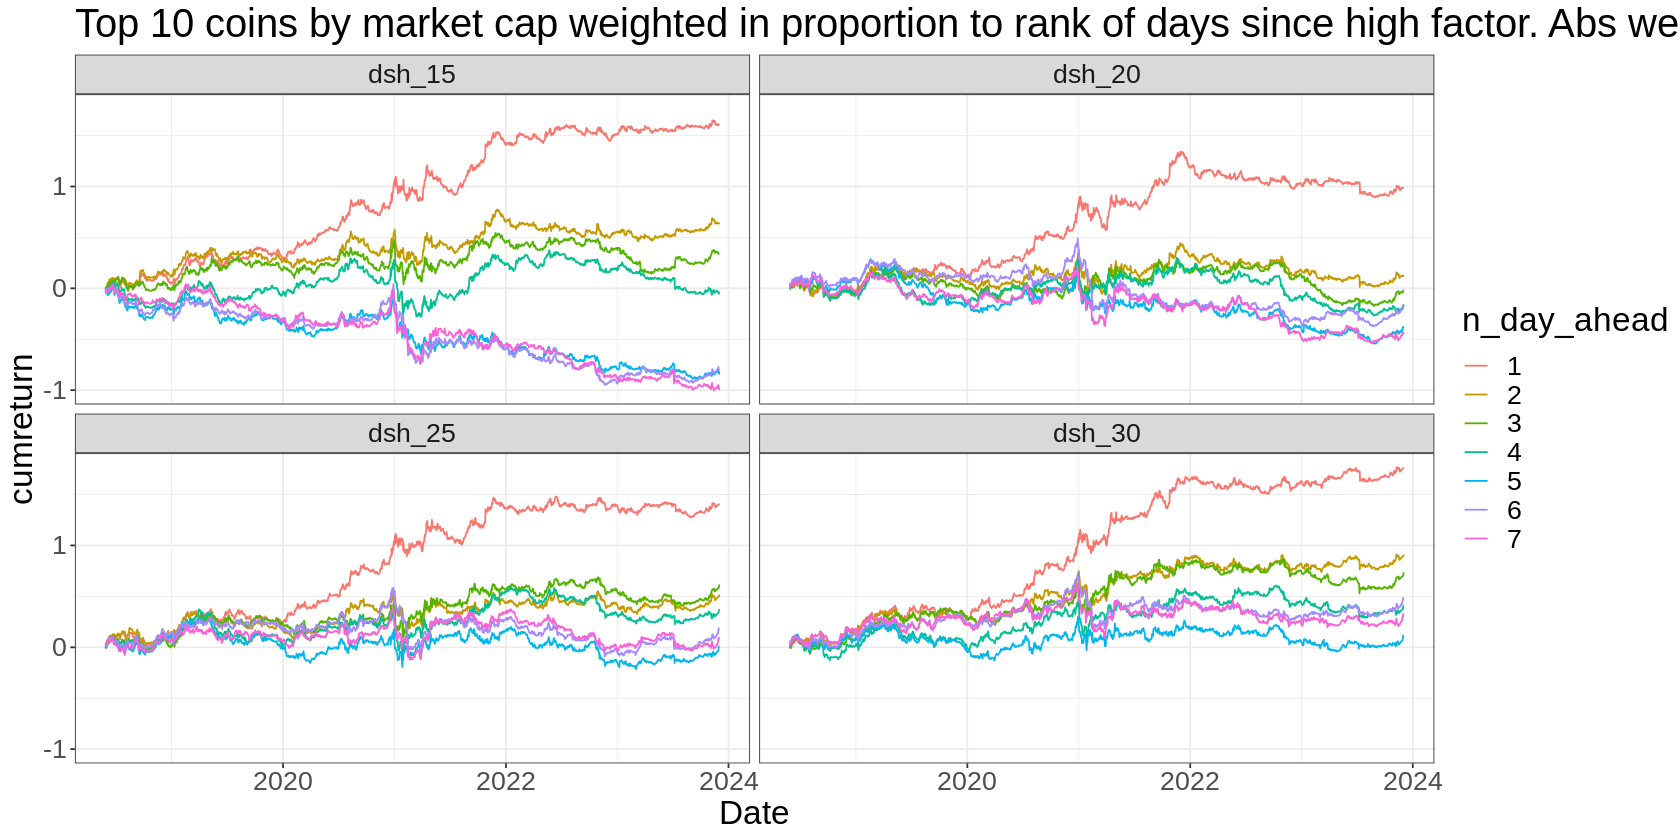

In [15]:
factor_lookback_returns <- features_wide %>%
  pivot_longer(starts_with('dsh'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(Date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(Date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return))

factor_lookback_returns %>%
  ggplot(aes(x=Date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of days since high factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>%
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365),
    ir = meanreturn / vol
  ) %>%
  arrange(desc(meanreturn))

# Mega-Factor


`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


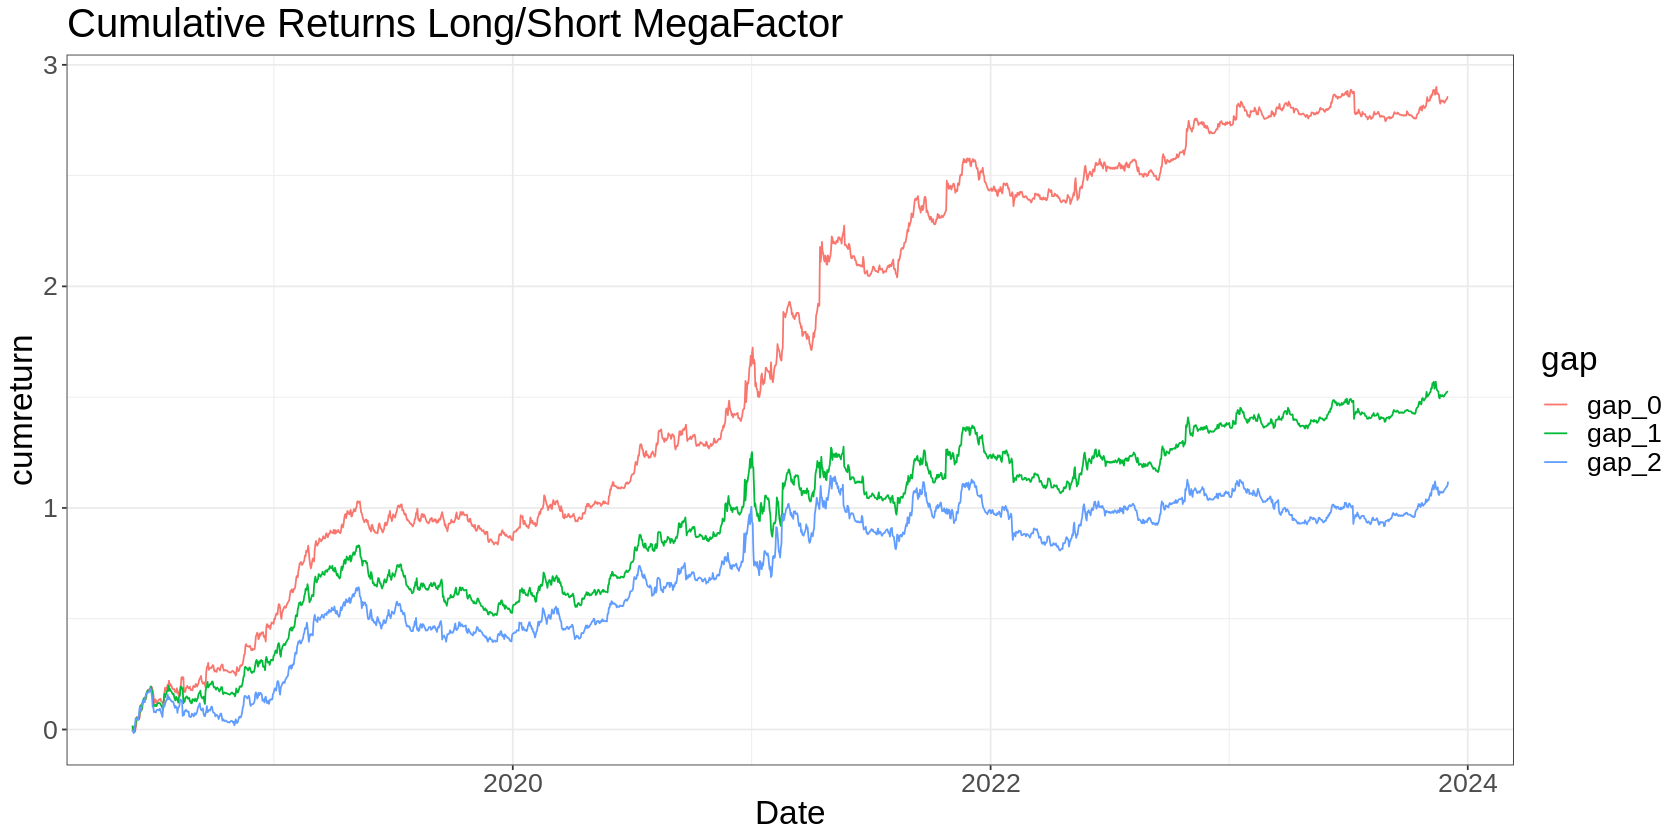

In [16]:
mom_ranks <- features_wide %>%
  pivot_longer(
    c(starts_with('mom_'), starts_with('psma_'), starts_with('smaf_'), starts_with('rrp_'), starts_with('dsh_')),
    names_to = 'feature',
    values_to = 'value'
  ) %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

megafactor <- mom_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor %>%
  inner_join(features_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  ) %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')


# What's Next?
- Let's check that results aren't an artefact of when we chose to snapshot our daily prices
- Tilt exposure based on time series momentum? Let's look at time series momentum factors
- Simulation + trading rules

